<a href="https://colab.research.google.com/github/PaulFroehling/Neural-Style-Transfer/blob/main/MultiStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

In [ ]:
content_layers = ['block5_conv2']
style_layers = ['block4_conv1','block4_conv2', 'block5_conv1', 'block5_conv2']
layer_names = content_layers + style_layers

no_style_layers = len(style_layers)
no_content_layers = len(content_layers)

style_weight =  0.15
content_weight = 0.02 
total_variation_weight = 20

In [ ]:
IMAGE_DIR = '/content/images'
#!mkdir {IMAGE_DIR}
!wget -q -O ./images/hochzeit.jpg /content/images/portrait_nn_2.jpg
!wget -q -O ./images/vangogh.jpg https://www.deutschlandfunk.de/media/thumbs/2/284beefc30729958bcbde09348c4a1b8v1_max_755x426_b3535db83dc50e27c1bb1392364c95a2.jpg?key=e1ba0a

!ls images

contentimg_path = '/content/images/portrait_2.jpg'
styleimg_path = '/content/images/style_for_nn.jpg'


hochzeit.jpg   portrait_1.jpg  portrait_nn_2.jpg  vangogh.jpg
Kandinsky.jpg  portrait_2.jpg  style_for_nn.jpg


In [ ]:


def calc_gram_matrix(input):
  gram_matrix = tf.linalg.einsum('bijc, bijd->bcd', input, input)
  in_shape = tf.shape(input)
  num_locations = tf.cast(in_shape[1] * in_shape[2], tf.float32)
  return gram_matrix/(num_locations)

def get_style_image_features(img):
  preprocessed_style_image = prep_imgs(img) 
  outputs = vgg(preprocessed_style_image) 
  style_outputs = outputs[:no_style_layers] 
  gram_style_features = [calc_gram_matrix(style_layer) for style_layer in style_outputs] 
  return gram_style_features


def get_content_image_features(img):
  prep_content_img = prep_imgs(img)
  content_outputs = vgg(prep_content_img)
  return content_outputs[no_style_layers:]


def calc_style_loss(ft, tgt):
  return tf.reduce_mean(tf.math.squared_difference(ft,tgt))

def calc_content_loss(ft, tgt):
  return 0.5*tf.reduce_sum(tf.math.squared_difference(ft,tgt))


def calc_style_content_loss(style_targets, style_outputs, content_targets, content_outputs, style_weight, content_weight):
  style_loss = tf.add_n([calc_style_loss(style_output, style_target) for style_output, style_target in zip(style_outputs, style_targets)])
  style_loss *= style_weight / no_style_layers
  content_loss = tf.add_n([calc_content_loss(content_output, content_target) for content_output, content_target in zip(content_outputs, content_targets)])
  content_loss *= content_weight / no_content_layers

  return style_loss + content_loss
   

def prep_imgs(img):
  #Center distribution of pixel values to 0. Required when feeding images to vgg19
  img =tf.keras.applications.vgg19.preprocess_input(img)

  return img


def calc_gradients(img, style_targets, content_targets,
                   style_weight, content_weight, var_weight):
  
  with tf.GradientTape() as tape:
    style_features = get_style_image_features(img)
    content_features = get_content_image_features(img)
    loss=calc_style_content_loss(style_targets, style_features,
                                 content_targets,content_features,
                                 style_weight, content_weight)
    
    loss += total_variation_weight + tf.image.total_variation(img)
    
    gradients = tape.gradient(loss, img)
    return gradients


def update_image_with_style(image, style_targets, content_targets, style_weight, 
                            var_weight, content_weight, optimizer):

  gradients = calc_gradients(image, style_targets, content_targets, 
                                  style_weight, content_weight, var_weight) 
  
  optimizer.apply_gradients([(gradients, image)]) 

  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))


def vgg_model(layer_names):
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable=False
  outputs=[vgg.get_layer(name).output for name in layer_names]
  model=tf.keras.Model(inputs=vgg.input, outputs=outputs)

  return model



def load_img(path_to_img):
  print(path_to_img)
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image

def load_content_and_style_image():
  content_img = load_img(contentimg_path)
  style_img = load_img(styleimg_path)

  return content_img, style_img


def tensor_to_image(tensor):
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 

def clip_image_values(image, min_value=0.0, max_value=255.0):
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)



def optimize_image(style_image, content_image, style_weight=0.01, content_weight=0.0001,
                   var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1):
  
  generated_images = []


  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image)
  generated_images.append(content_image)

  style_targets = get_style_image_features(style_image)
  content_targets = get_content_image_features(content_image)

  for i in range(0, epochs):
    for j in range(0, steps_per_epoch):

      update_image_with_style(generated_image, style_targets, content_targets, 
                              style_weight, var_weight, content_weight, optimizer) 
    
      
      if j%50==0: 
        generated_images.append(generated_image)
        clear_output(wait=True)
        display_image = tensor_to_image(generated_image)
        display_fn(display_image)

        print("Epoch: "+str(i)+" Step: "+str(j))

  return generated_images
    

Content image on the left, style image on the right

/content/images/portrait_2.jpg
/content/images/style_for_nn.jpg


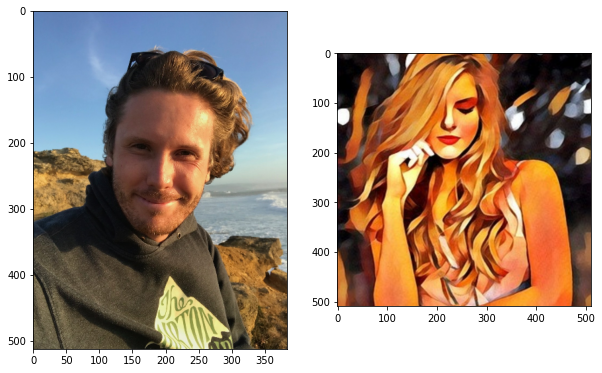

In [ ]:
content_img, style_img = load_content_and_style_image()
images_plot = [content_img, style_img]
plt.figure(figsize=(10, 7))
for i in range(0, 2):
  plt.subplot(1,2, i+1)
  plt.imshow(images_plot[i][0])

In [ ]:
tf.keras.backend.clear_session()

vgg = vgg_model(layer_names)

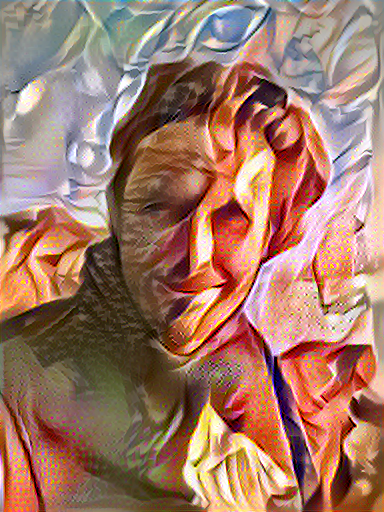

Epoch: 6 Step: 50


In [ ]:
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=15.0, decay_steps=100, decay_rate=0.60
    )
)

stylized_images = optimize_image(style_image=style_img, content_image=content_img, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=0, optimizer=adam, epochs=7, steps_per_epoch=100)